In [ ]:
#Import necessary libraries
import os
import json
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import pandas as pd
import torch.nn as nn

Read the json file having annotation to create the custom dataset of image and the masked image

In [ ]:
json_file='/content/drive/MyDrive/Colab Notebooks/DL_project_updated_68_json.json'

In [ ]:
import random
# Set random seeds for reproducibility 
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make a dataframe of the annotated json and so necessary preprocessing 

In [ ]:
annotation_df= pd.read_json(json_file)
annotation_df = annotation_df.transpose().reset_index()[['filename','regions']]
shape_attributes = []
for row in range(annotation_df.shape[0]):
    data = annotation_df['regions'][row][0]['shape_attributes']
    shape_attributes.append(data)
region_attributes = []
for row in range(annotation_df.shape[0]):
    data = annotation_df['regions'][row][0]['region_attributes']
    region_attributes.append(data)  
shape_attributes_df = pd.DataFrame(shape_attributes)
shape_attributes_df= shape_attributes_df.rename(columns= {"name": "shape_name"})    

region_attributes_df = pd.DataFrame(region_attributes)
region_attributes_df= region_attributes_df.rename(columns= {"name": "object_name"})

annotation_df = pd.concat([annotation_df,shape_attributes_df, region_attributes_df],1)
annotation_df

<ipython-input-6-36a455c192cc>:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  annotation_df = pd.concat([annotation_df,shape_attributes_df, region_attributes_df],1)


filename                                            regions  \
0     IMG_0062.png  [{'shape_attributes': {'name': 'polyline', 'al...   
1     IMG_0068.png  [{'shape_attributes': {'name': 'polyline', 'al...   
2     IMG_0079.png  [{'shape_attributes': {'name': 'polyline', 'al...   
3     IMG_0081.png  [{'shape_attributes': {'name': 'polyline', 'al...   
4     IMG_0083.png  [{'shape_attributes': {'name': 'polyline', 'al...   
..             ...                                                ...   
63    IMG_0122.png  [{'shape_attributes': {'name': 'polygon', 'all...   
64    IMG_0129.png  [{'shape_attributes': {'name': 'polygon', 'all...   
65    IMG_0130.png  [{'shape_attributes': {'name': 'polygon', 'all...   
66    IMG_0135.png  [{'shape_attributes': {'name': 'polygon', 'all...   
67  IMG_0301 2.JPG  [{'shape_attributes': {'name': 'polygon', 'all...   

   shape_name                                       all_points_x  \
0    polyline               [616, 664, 761, 869, 911, 0, 6, 622]   
1    polyline  [12, 0, 416, 489, 700, 863, 1237, 1328, 1545, ...   
2    polyline  [6, 60, 97, 139, 199, 181, 217, 229, 0, 0, 205...   
3    polyline                              [12, 561, 616, 6, 12]   
4    polyline  [6, 338, 483, 984, 2276, 1986, 1859, 1781, 203...   
..        ...                                                ...   
63    polygon  [16, 1062, 1070, 1264, 1264, 1835, 3010, 3018,...   
64    polygon  [16, 1384, 3002, 3010, 1803, 1829, 1527, 930, ...   
65    polygon  [1135, 1433, 2052, 2068, 2036, 1883, 1690, 146...   
66    polygon  [16, 684, 1891, 3010, 3002, 2712, 2640, 2511, ...   
67    polygon  [126, 241, 301, 274, 251, 225, 175, 106, 30, 0...   

                                         all_points_y object_name      type  \
0          [3169, 2499, 1515, 519, 12, 6, 3175, 3169]    building  building   
1   [2547, 2873, 2879, 2873, 2855, 2801, 2813, 280...    building  building   
2   [2789, 2710, 2270, 1624, 1086, 899, 911, 561, ...    Building  building   
3                      [2559, 2571, 2583, 2529, 2559]      Road\n      road   
4   [2451, 2432, 2445, 2390, 2282, 2215, 2185, 218...      Road\n      road   
..                                                ...         ...       ...   
63  [1054, 1368, 1400, 1457, 1505, 1658, 1288, 269...    Building  building   
64  [8, 0, 1360, 2656, 2624, 3591, 3857, 4020, 401...    Building  building   
65  [1690, 1505, 1714, 2302, 2463, 2503, 2503, 250...    Building  building   
66  [1497, 137, 821, 1465, 3694, 3750, 3750, 3766,...    Building  building   
67  [678, 813, 870, 982, 1081, 1144, 1137, 1111, 1...    Building  building   

                                        image_quality  
0                     {'good': True, 'frontal': True}  
1   {'good': True, 'good_illumination': True, 'sid...  
2   {'good': True, 'good_illumination': True, 'sid...  
3      {'good': True, 'side': True, 'far away': True}  
4   {'good': True, 'frontal': True, 'good_illumina...  
..                                                ...  
63  {'good': True, 'frontal': True, 'good_illumina...  
64  {'good': True, 'good_illumination': True, 'sid...  
65  {'good': True, 'frontal': True, 'good_illumina...  
66  {'good': True, 'good_illumination': True, 'sid...  
67  {'good': True, 'frontal': True, 'good_illumina...  

[68 rows x 8 columns]

In [ ]:
# Define image directory and the directory for the Masked Images
img_dir = '/content/drive/MyDrive/Colab Notebooks/Training_images_68'
save_dir ='/content/drive/MyDrive/Colab Notebooks/Masked Images'

The below code is for the saved model DenseASPP_finetuned.pth model where the classes of images have been set as:      if class_name == 'building':
            color = (255, 0, 0)
        elif class_name == 'tree':
            color = (0, 255, 0)
        elif class_name == 'road':
            color = (0, 0, 255)

In [ ]:
'''import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from ast import literal_eval
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations_df, transform=None, save_dir=None):
        self.img_dir = img_dir
        self.annotations_df = annotations_df
        self.transform = transform
        self.save_dir = save_dir
        print(f"save_dir: {save_dir}")
        if self.save_dir and not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        # load image
        img_name = self.annotations_df.iloc[idx]["filename"]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)

        # load annotation
        regions = self.annotations_df.iloc[idx]["regions"]

        # create multi-channel mask from annotation
        mask = create_mask_from_annotation(regions, img.shape[:2])

        # Resize image
        height, width = img.shape[:2]
        new_height, new_width = 256, 256  # change these values to your desired size
        img = cv2.resize(img, (new_width, new_height))

        # Resize mask
        mask = cv2.resize(mask, (new_width, new_height))

        # apply transform if specified
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]

        # save masked image to disk
        if self.save_dir:
            save_path = os.path.join(self.save_dir, f"{img_name[:-4]}_masked.jpg")
            print(f"Saving masked image to {save_path}")
            masked_img = cv2.bitwise_and(img, mask)
            if masked_img.shape[2] > 4:
                masked_img = masked_img[:, :, :3]  # convert to RGB
            print(f"Masked image shape: {masked_img.shape}")
            cv2.imwrite(save_path, masked_img)
            print("Saved masked image")
        
        # convert to tensor and return
        img = img.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))

        return img, mask
#Partition your dataset into 80% training, 10% validation, and 10% test.


def create_mask_from_annotation(regions, image_size):
    """
    Create a multi-channel binary mask from annotation regions.
    
    Args:
        regions: annotation regions
        image_size: size of the image
        
    Returns:
        A multi-channel binary mask with one channel for each class
    """
    mask = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    
    # iterate over each region
    for region in regions:
        # get shape attributes
        shape_attributes = region['shape_attributes']
        all_points_x = shape_attributes['all_points_x']
        all_points_y = shape_attributes['all_points_y']
        
        # get region attributes
        region_attributes = region['region_attributes']
        class_name = region_attributes['type']
        
        # set mask values based on class
        if class_name == 'building':
            color = (255, 0, 0)
        elif class_name == 'tree':
            color = (0, 255, 0)
        elif class_name == 'road':
            color = (0, 0, 255)
        else:
            raise ValueError(f"Unknown class name: {class_name}")
        
        # create mask for region
        polygon = list(zip(all_points_x, all_points_y))
        polygon = np.array(polygon, np.int32)
        cv2.fillPoly(mask, [polygon], color)
    
    return mask

import numpy as np
from torch.utils.data import DataLoader, random_split

# define dataset and split into train, val, test
dataset = CustomDataset(img_dir, annotation_df)
num_data = len(dataset)
train_size = int(0.8 * num_data)
val_size = int(0.1 * num_data)
test_size = num_data - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))


import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define the batch size
batch_size = 8

# Create data loaders for the three sets
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True)
 
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)'''

'import os\nimport cv2\nimport numpy as np\nimport pandas as pd\nimport torch\nimport torch.nn as nn\nfrom ast import literal_eval\nfrom torch.utils.data import Dataset\n\n\nclass CustomDataset(Dataset):\n    def __init__(self, img_dir, annotations_df, transform=None, save_dir=None):\n        self.img_dir = img_dir\n        self.annotations_df = annotations_df\n        self.transform = transform\n        self.save_dir = save_dir\n        print(f"save_dir: {save_dir}")\n        if self.save_dir and not os.path.exists(self.save_dir):\n            os.makedirs(self.save_dir)\n\n    def __len__(self):\n        return len(self.annotations_df)\n\n    def __getitem__(self, idx):\n        # load image\n        img_name = self.annotations_df.iloc[idx]["filename"]\n        img_path = os.path.join(self.img_dir, img_name)\n        img = cv2.imread(img_path)\n\n        # load annotation\n        regions = self.annotations_df.iloc[idx]["regions"]\n\n        # create multi-channel mask from annotation

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from ast import literal_eval
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations_df, transform=None, save_dir=None):
        self.img_dir = img_dir
        self.annotations_df = annotations_df
        self.transform = transform
        self.save_dir = save_dir
        print(f"save_dir: {save_dir}")
        if self.save_dir and not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        # load image
        img_name = self.annotations_df.iloc[idx]["filename"]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)

        # load annotation
        regions = self.annotations_df.iloc[idx]["regions"]

        # create multi-channel mask from annotation
        mask = create_mask_from_annotation(regions, img.shape[:2])

        # Convert NumPy arrays to PIL format
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)
        # Apply transform if specified
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        
        img = np.array(img)
        mask = np.array(mask)
        
        # save masked image to disk
        if self.save_dir:
            save_path = os.path.join(self.save_dir, f"{img_name[:-4]}_masked.jpg")
            print(f"Saving masked image to {save_path}")
            masked_img = cv2.bitwise_and(img, mask)
            masked_img = masked_img.transpose((1, 2, 0))  # convert to (height, width, channels)
            if masked_img.shape[2] > 4:
                masked_img = masked_img[:, :, :3]  # convert to RGB
            print(f"Masked image shape: {masked_img.shape}")
            cv2.imwrite(save_path, masked_img)
            print("Saved masked image")
        
        # convert to tensor and return
        img = img.transpose((0, 1, 2))
        mask = mask.transpose((0, 1, 2))

        return img, mask




def create_mask_from_annotation(regions, image_size):
    """
    Create a multi-channel binary mask from annotation regions.
    
    Args:
        regions: annotation regions
        image_size: size of the image
        
    Returns:
        A multi-channel binary mask with one channel for each class
    """
    mask = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    
    # iterate over each region
    for region in regions:
        # get shape attributes
        shape_attributes = region['shape_attributes']
        all_points_x = shape_attributes['all_points_x']
        all_points_y = shape_attributes['all_points_y']
        
        # get region attributes
        region_attributes = region['region_attributes']
        class_name = region_attributes['type']
        
        # set mask values based on class
        if class_name == 'road':
            color = (255, 0, 0)
        elif class_name == 'tree':
            color = (0, 255, 0)
        elif class_name == 'building':
            color = (0, 0, 255)
        else: # set all other pixels to black
            color = (0, 0, 0)

        
        # create mask for region
        polygon = list(zip(all_points_x, all_points_y))
        polygon = np.array(polygon, np.int32)
        cv2.fillPoly(mask, [polygon], color)
    
    return mask

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])


from torch.utils.data import DataLoader


# Create the full dataset
dataset = CustomDataset(img_dir, annotation_df, transform=train_transform, save_dir=None)

num_data = len(dataset)
train_size = int(0.8 * num_data)
val_size = int(0.1 * num_data)
test_size = num_data - train_size - val_size



train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

# Compute mean and standard deviation for normalization
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
mean = 0.
std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)

print(f"Mean: {mean}")
print(f"Std: {std}")

# Define transform with normalization
normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

train_dataset.transform = transforms.Compose([
    train_transform,
    normalize
])

val_dataset.transform = transforms.Compose([
    val_transform,
    normalize
])

test_dataset.transform = transforms.Compose([
    test_transform,
    normalize
])



# Create dataloaders for each subset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


save_dir: None
Mean: tensor([0.5664, 0.5783, 0.5765])
Std: tensor([0.2889, 0.2527, 0.2364])


In [ ]:
from torch.utils.data import DataLoader

# Instantiate the dataset
augmented_dataset = CustomDataset(img_dir, annotation_df,  transform=train_transform, save_dir=save_dir)

# Create a DataLoader object
data_loader = DataLoader(augmented_dataset, batch_size=8, shuffle=True)

# Iterate over the DataLoader and save the masked images
for batch in data_loader:
    pass  # The actual code for processing each batch goes here

save_dir: /content/drive/MyDrive/Colab Notebooks/Masked Images
Saving masked image to /content/drive/MyDrive/Colab Notebooks/Masked Images/IMG_0097_masked.jpg
Masked image shape: (224, 224, 3)
Saved masked image
Saving masked image to /content/drive/MyDrive/Colab Notebooks/Masked Images/IMG_0135_masked.jpg
Masked image shape: (224, 224, 3)
Saved masked image
Saving masked image to /content/drive/MyDrive/Colab Notebooks/Masked Images/IMG_0301 2_masked.jpg
Masked image shape: (224, 224, 3)
Saved masked image
Saving masked image to /content/drive/MyDrive/Colab Notebooks/Masked Images/IMG_0087_masked.jpg
Masked image shape: (224, 224, 3)
Saved masked image
Saving masked image to /content/drive/MyDrive/Colab Notebooks/Masked Images/IMG_0080_masked.jpg
Masked image shape: (224, 224, 3)
Saved masked image
Saving masked image to /content/drive/MyDrive/Colab Notebooks/Masked Images/IMG_0111_masked.jpg
Masked image shape: (224, 224, 3)
Saved masked image
Saving masked image to /content/drive/MyD

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F



# Define a function to plot the first sample of each minibatch
def plot_samples(data_loader):
    
  images, masks = next(iter(data_loader))
  

  # plot image and mask side by side
  fig, ax = plt.subplots(1, 2, figsize=(15, 10))
  ax[0].imshow(images[0].permute(1,2,0))
  ax[1].imshow(masks[0].permute(1,2,0))
  plt.show()


In [ ]:
print(len(train_loader))

7


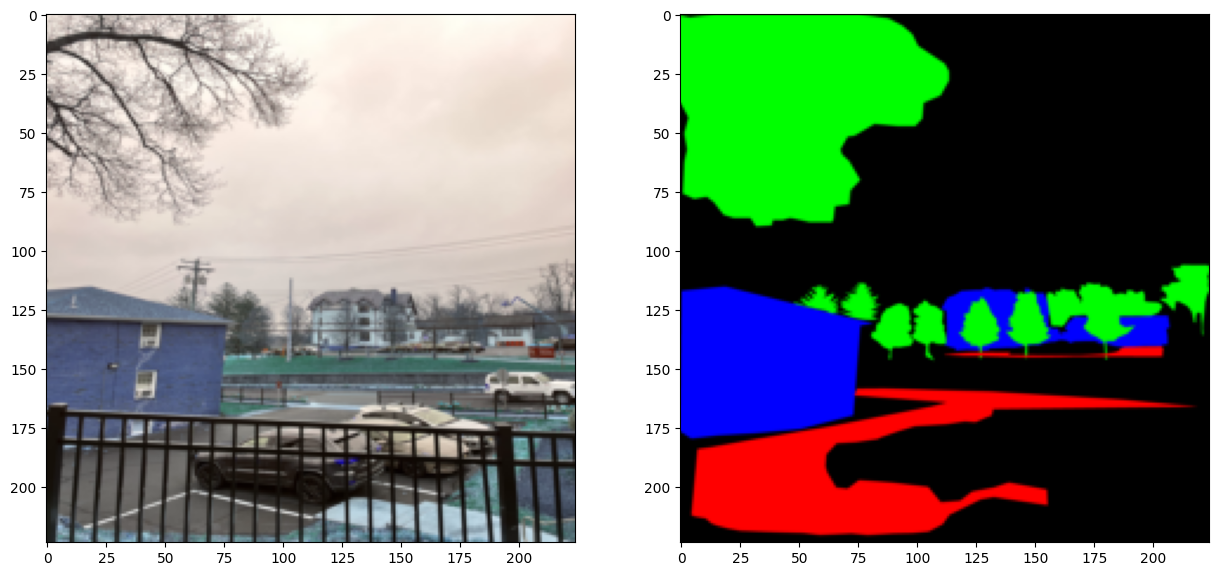

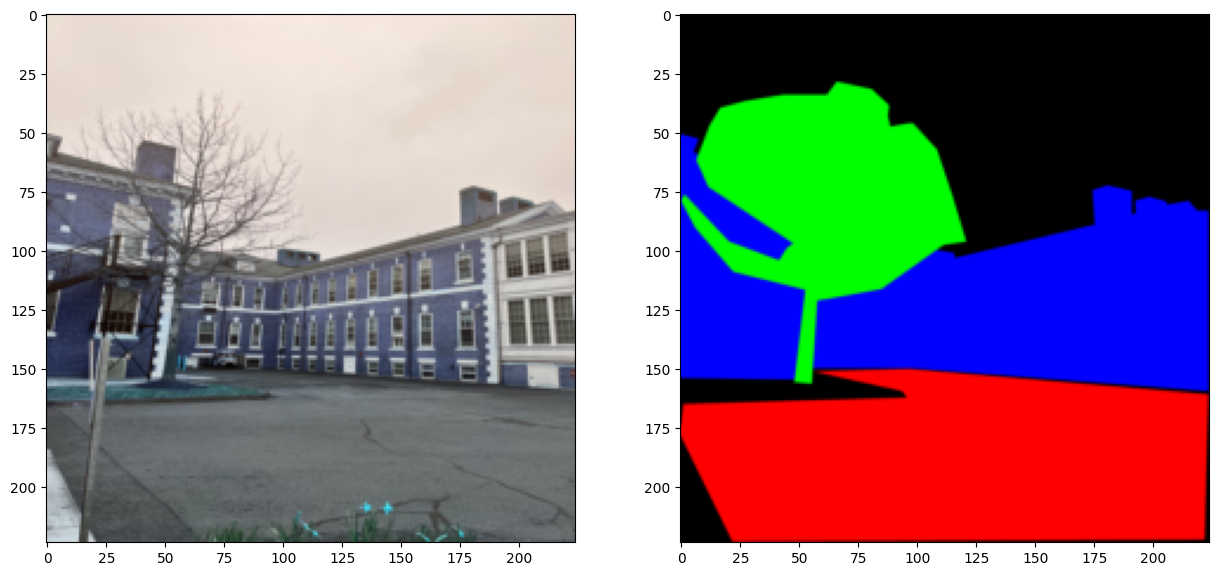

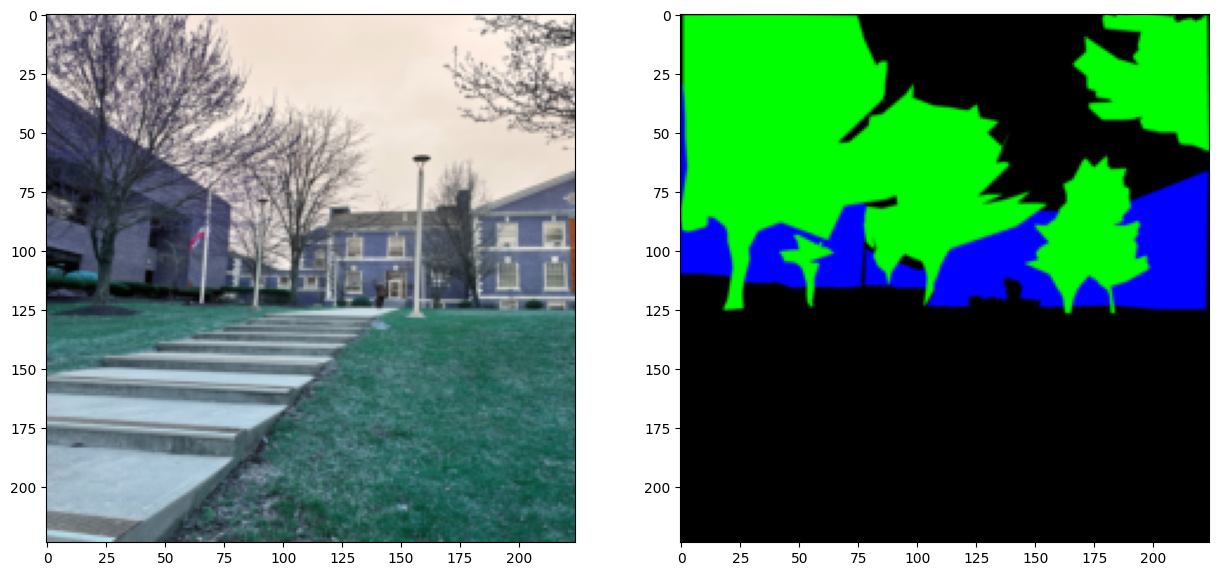

In [ ]:
# Plot the first sample of each minibatch in the training set
plot_samples(train_loader)

# Plot the first sample of each minibatch in the validation set
plot_samples(val_loader)

# Plot the first sample of each minibatch in the test set
plot_samples(test_loader)



Using the code of the DenseASPP model discussed in paper https://ieeexplore-ieee-org.unh-proxy01.newhaven.edu/stamp/stamp.jsp?tp=&arnumber=8578486&tag=1 . The code is in https://github.com/DeepMotionAIResearch/DenseASPP 


In [ ]:

Model_CFG = {
    'bn_size': 4,
    'drop_rate': 0,
    'growth_rate': 48,
    'num_init_features': 96,
    'block_config': (6, 12, 36, 24),

    'dropout0': 0.1,
    'dropout1': 0.1,
    'd_feature0': 512,
    'd_feature1': 128,

    'pretrained_path': "./pretrained/densenet161.pth"
}

In [ ]:
import torch
import torch.nn.functional as F

from torch import nn
from collections import OrderedDict
from torch.nn import BatchNorm2d as bn


class DenseASPP(nn.Module):
    """
    * output_scale can only set as 8 or 16
    """
    def __init__(self, model_cfg, n_class=19, output_stride=8):
        super(DenseASPP, self).__init__()
        bn_size = model_cfg['bn_size']
        drop_rate = model_cfg['drop_rate']
        growth_rate = model_cfg['growth_rate']
        num_init_features = model_cfg['num_init_features']
        block_config = model_cfg['block_config']

        dropout0 = model_cfg['dropout0']
        dropout1 = model_cfg['dropout1']
        d_feature0 = model_cfg['d_feature0']
        d_feature1 = model_cfg['d_feature1']

        feature_size = int(output_stride / 8)

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', bn(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        # block1*****************************************************************************************************
        block = _DenseBlock(num_layers=block_config[0], num_input_features=num_features,
                            bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
        self.features.add_module('denseblock%d' % 1, block)
        num_features = num_features + block_config[0] * growth_rate

        trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
        self.features.add_module('transition%d' % 1, trans)
        num_features = num_features // 2

        # block2*****************************************************************************************************
        block = _DenseBlock(num_layers=block_config[1], num_input_features=num_features,
                            bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
        self.features.add_module('denseblock%d' % 2, block)
        num_features = num_features + block_config[1] * growth_rate

        trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2, stride=feature_size)
        self.features.add_module('transition%d' % 2, trans)
        num_features = num_features // 2

        # block3*****************************************************************************************************
        block = _DenseBlock(num_layers=block_config[2], num_input_features=num_features, bn_size=bn_size,
                            growth_rate=growth_rate, drop_rate=drop_rate, dilation_rate=int(2 / feature_size))
        self.features.add_module('denseblock%d' % 3, block)
        num_features = num_features + block_config[2] * growth_rate

        trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2, stride=1)
        self.features.add_module('transition%d' % 3, trans)
        num_features = num_features // 2

        # block4*****************************************************************************************************
        block = _DenseBlock(num_layers=block_config[3], num_input_features=num_features, bn_size=bn_size,
                            growth_rate=growth_rate, drop_rate=drop_rate, dilation_rate=int(4 / feature_size))
        self.features.add_module('denseblock%d' % 4, block)
        num_features = num_features + block_config[3] * growth_rate

        trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2, stride=1)
        self.features.add_module('transition%d' % 4, trans)
        num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', bn(num_features))
        if feature_size > 1:
            self.features.add_module('upsample', nn.Upsample(scale_factor=2, mode='bilinear'))

        self.ASPP_3 = _DenseAsppBlock(input_num=num_features, num1=d_feature0, num2=d_feature1,
                                      dilation_rate=3, drop_out=dropout0, bn_start=False)

        self.ASPP_6 = _DenseAsppBlock(input_num=num_features + d_feature1 * 1, num1=d_feature0, num2=d_feature1,
                                      dilation_rate=6, drop_out=dropout0, bn_start=True)

        self.ASPP_12 = _DenseAsppBlock(input_num=num_features + d_feature1 * 2, num1=d_feature0, num2=d_feature1,
                                       dilation_rate=12, drop_out=dropout0, bn_start=True)

        self.ASPP_18 = _DenseAsppBlock(input_num=num_features + d_feature1 * 3, num1=d_feature0, num2=d_feature1,
                                       dilation_rate=18, drop_out=dropout0, bn_start=True)

        self.ASPP_24 = _DenseAsppBlock(input_num=num_features + d_feature1 * 4, num1=d_feature0, num2=d_feature1,
                                       dilation_rate=24, drop_out=dropout0, bn_start=True)
        num_features = num_features + 5 * d_feature1

        self.classification = nn.Sequential(
            nn.Dropout2d(p=dropout1),
            nn.Conv2d(in_channels=num_features, out_channels=n_class, kernel_size=1, padding=0),
            nn.Upsample(scale_factor=8, mode='bilinear'),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform(m.weight.data)

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, _input):
        feature = self.features(_input)

        aspp3 = self.ASPP_3(feature)
        feature = torch.cat((aspp3, feature), dim=1)

        aspp6 = self.ASPP_6(feature)
        feature = torch.cat((aspp6, feature), dim=1)

        aspp12 = self.ASPP_12(feature)
        feature = torch.cat((aspp12, feature), dim=1)

        aspp18 = self.ASPP_18(feature)
        feature = torch.cat((aspp18, feature), dim=1)

        aspp24 = self.ASPP_24(feature)
        feature = torch.cat((aspp24, feature), dim=1)

        cls = self.classification(feature)

        return cls


class _DenseAsppBlock(nn.Sequential):
    """ ConvNet block for building DenseASPP. """

    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True):
        super(_DenseAsppBlock, self).__init__()
        if bn_start:
            self.add_module('norm1', bn(input_num, momentum=0.0003)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', bn(num1, momentum=0.0003)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),

        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(_DenseAsppBlock, self).forward(_input)

        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)

        return feature


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, dilation_rate=1):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', bn(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', bn(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, dilation=dilation_rate, padding=dilation_rate, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, dilation_rate=1):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate,
                                bn_size, drop_rate, dilation_rate=dilation_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features, stride=2):
        super(_Transition, self).__init__()
        self.add_module('norm', bn(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False))
        if stride == 2:
            self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=stride))
            
if __name__ == "__main__":
    model = DenseASPP(Model_CFG)
    print(model)            

<ipython-input-14-8a2e3d5b6e28>:107: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


DenseASPP(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [ ]:
device='cuda'

In [ ]:
# Load the pre-trained DenseASPP model weights
model_path = '/content/drive/MyDrive/Colab Notebooks/denseASPP161_795.pkl'
state_dict = torch.load(model_path, map_location=torch.device('cpu'))

num_classes = 3  # number of classes in your dataset

print(len(model.state_dict())) 

print(len(state_dict))

1038
867


### These are the parameters of the pretrained model.

In [ ]:
state_dict

OrderedDict([('module.features.conv0.weight',
              tensor([[[[-1.2140e-01, -2.0185e-01, -2.4670e-01,  ..., -2.4109e-01,
                         -2.0833e-01, -1.5888e-01],
                        [-1.5540e-01, -2.1924e-01, -2.6246e-01,  ..., -2.6303e-01,
                         -2.2671e-01, -1.8107e-01],
                        [-9.6531e-02, -1.3960e-01, -1.6738e-01,  ..., -1.5737e-01,
                         -1.5574e-01, -1.3002e-01],
                        ...,
                        [ 6.1339e-02,  9.7127e-02,  1.2587e-01,  ...,  1.3780e-01,
                          1.1476e-01,  9.5124e-02],
                        [ 1.2907e-01,  1.9631e-01,  2.2291e-01,  ...,  2.4816e-01,
                          1.9473e-01,  1.4228e-01],
                        [ 1.4260e-01,  2.5408e-01,  3.0888e-01,  ...,  3.0830e-01,
                          2.3173e-01,  1.8146e-01]],
              
                       [[-1.3498e-01, -2.1795e-01, -2.7797e-01,  ..., -2.8237e-01,
                

## We need to change the dictionary of the loaded parameters as there are some inconsitencies with the current version of Pytorch.

In [ ]:
# Rename the keys in the state_dict
new_model_dict = {}
for k, v in state_dict.items():
    name = k.replace('norm.1', 'norm1')
    name = name.replace('norm.2', 'norm2')
    name = name.replace('relu.1', 'relu1')
    name = name.replace('relu.2', 'relu2')
    name = name.replace('conv.1', 'conv1')
    name = name.replace('conv.2', 'conv2')
    new_model_dict[name] = v

# Create a new dictionary with modified keys
new_dict = {}
for key in new_model_dict:
    if key.startswith("module."):
        new_key = key[len("module."):]
    else:
        new_key = key
    new_dict[new_key] = new_model_dict[key]

# Add the num_batches_tracked key after running_var
new_state_dict = {}
for key in new_dict:
    if 'running_var' in key:
        # add the num_batches_tracked key after running_var
        idx = key.find('running_var')
        new_key = key[:idx] + 'num_batches_tracked' 
        new_state_dict[key] = new_dict[key]
        new_state_dict[new_key] = torch.zeros_like(new_dict[key])
    else:
        new_state_dict[key] = new_dict[key]

In [ ]:
print(len(model.state_dict())) 

print(len(new_state_dict))

1038
1038


In [ ]:

# Create a new model and load the modified state_dict
model = DenseASPP(Model_CFG)
model.load_state_dict(new_state_dict)


<ipython-input-14-8a2e3d5b6e28>:107: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


<All keys matched successfully>

In [ ]:
model

DenseASPP(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [ ]:
last_layer = model.classification[-2] # Access the second to last layer of the classification module
in_features = last_layer.weight.size(1)
print("Number of input features:", in_features)

Number of input features: 1744


In [ ]:
#We can get the number of input features of the classification layer from the new_state_dict as well
# Get the last layer's weight tensor and its shape
last_layer_weight = new_state_dict['classification.1.weight']
last_layer_shape = last_layer_weight.shape

# Calculate the number of input features (input channels * height* weight)
in_features = last_layer_shape[1] * last_layer_shape[2] * last_layer_shape[3]

print(f"The number of input features of the last layer is: {in_features}")

The number of input features of the last layer is: 1744


In [ ]:
def find_lr(model, train_loader, val_loader, criterion, lr_list, num_epochs=20, patience=10):
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    early_stop_count = 0
    best_lr = None

    # Train the model with varying learning rates
    for i, lr in enumerate(lr_list):
        # Define optimizer with current lr
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        # Train the model with the current learning rate
        model.train()
        epoch_train_losses = []
        epoch_val_losses = []
        for epoch in range(num_epochs):
            train_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs.float())
                targets = torch.argmax(targets, dim=1)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Compute the validation loss with the current learning rate
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs.float())
                    targets = torch.argmax(targets, dim=1)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                avg_val_loss = val_loss / len(val_loader.dataset)

            epoch_train_losses.append(train_loss / len(train_loader.dataset))
            epoch_val_losses.append(avg_val_loss)

            # Check for early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                early_stop_count = 0
                best_lr = lr
            else:
                early_stop_count += 1
                if early_stop_count == patience:
                    print(f"Stopping early at LR: {lr:.5f} because of no improvement for {patience} epochs")
                    break

        train_losses.append(epoch_train_losses)
        val_losses.append(epoch_val_losses)

        print(f" {i+1}/{len(lr_list)}: LR: {lr:.5f}, Train Loss: {epoch_train_losses[-1]:.5f}, Val Loss: {epoch_val_losses[-1]:.5f}")

    return best_lr, val_losses

In [ ]:
import numpy as np
lr_list = np.logspace(np.log10(1e-6), np.log10(0.1), num=5)
print (lr_list)

[1.00000000e-06 1.77827941e-05 3.16227766e-04 5.62341325e-03
 1.00000000e-01]


 1/5: LR: 0.00000, Train Loss: 0.13617, Val Loss: 0.17553
 2/5: LR: 0.00003, Train Loss: 0.13408, Val Loss: 0.17237
 3/5: LR: 0.00100, Train Loss: 0.10204, Val Loss: 0.12790
 4/5: LR: 0.03162, Train Loss: 0.04142, Val Loss: 0.05587
Stopping early at LR: 1.00000 because of no improvement for 10 epochs
 5/5: LR: 1.00000, Train Loss: 0.21084, Val Loss: 0.12175


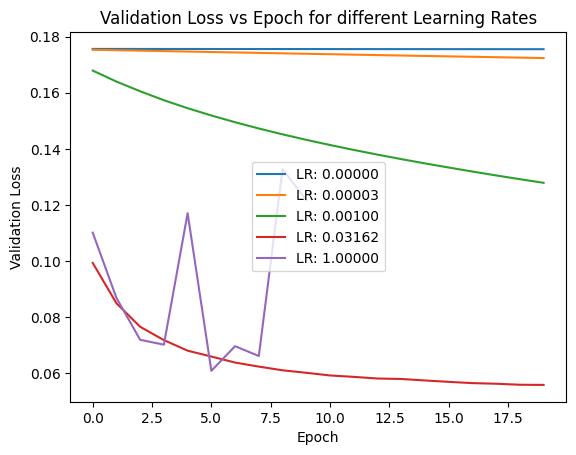

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

n_class = 3

# Modify the last layer of the model to have three output classes
model.classification = nn.Sequential(
    nn.Dropout2d(p=0.1),
    nn.Conv2d(in_channels=in_features, out_channels=n_class, kernel_size=1, padding=0),
    nn.Upsample(scale_factor=8, mode='bilinear'),
)

# Set the last layer to require gradients
for param in model.classification.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

model= model.to(device)
lr_list = np.logspace(np.log10(1e-6), np.log10(1), num=5)
best_lr, val_losses = find_lr(model, train_loader, val_loader, criterion, lr_list)

# Plot the losses vs. epochs for all learning rates
for i, lr in enumerate(lr_list):
    plt.plot(range(len(val_losses[i])), val_losses[i], label=f"LR: {lr:.5f}")

plt.title("Validation Loss vs Epoch for different Learning Rates")
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()



In [ ]:
print(best_lr)

0.03162277660168379


In [ ]:
def find_momentum(model, train_loader, val_loader, criterion, lr, momentum_list, num_epochs=20, patience=10):
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    early_stop_count = 0

    # Train the model with varying momentums
    for i, momentum in enumerate(momentum_list):
        # Define optimizer with current momentum and best learning rate
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=momentum)

        # Train the model with the current momentum
        model.train()
        epoch_train_losses = []
        epoch_val_losses = []
        for epoch in range(num_epochs):
            train_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs.float())
                targets = torch.argmax(targets, dim=1)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Compute the validation loss with the current momentum
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs.float())
                    targets = torch.argmax(targets, dim=1)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                avg_val_loss = val_loss / len(val_loader.dataset)

            epoch_train_losses.append(train_loss / len(train_loader.dataset))
            epoch_val_losses.append(avg_val_loss)

            # Check for early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_momentum = momentum
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count == patience:
                    print(f"Stopping early at momentum: {momentum:.5f} because of no improvement for {patience} epochs")
                    break

        train_losses.append(epoch_train_losses)
        val_losses.append(epoch_val_losses)

        print(f" {i+1}/{len(momentum_list)}: Momentum: {momentum:.5f}, Train Loss: {epoch_train_losses[-1]:.5f}, Val Loss: {epoch_val_losses[-1]:.5f}")

    # Plot the losses vs. epochs for the best momentum
    best_momentum_idx = momentum_list.index(best_momentum)
    plt.plot(range(len(val_losses[best_momentum_idx])), val_losses[best_momentum_idx], label="Val")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Validation Loss vs Epochs for Momentum = {best_momentum}")
    plt.legend()
    plt.show()

    return best_momentum


 1/4: Momentum: 0.00000, Train Loss: 0.01928, Val Loss: 0.05634
Stopping early at momentum: 0.50000 because of no improvement for 10 epochs
 2/4: Momentum: 0.50000, Train Loss: 0.01954, Val Loss: 0.05641
Stopping early at momentum: 0.90000 because of no improvement for 10 epochs
 3/4: Momentum: 0.90000, Train Loss: 0.01925, Val Loss: 0.05589
Stopping early at momentum: 0.99000 because of no improvement for 10 epochs
 4/4: Momentum: 0.99000, Train Loss: 0.01848, Val Loss: 0.05796


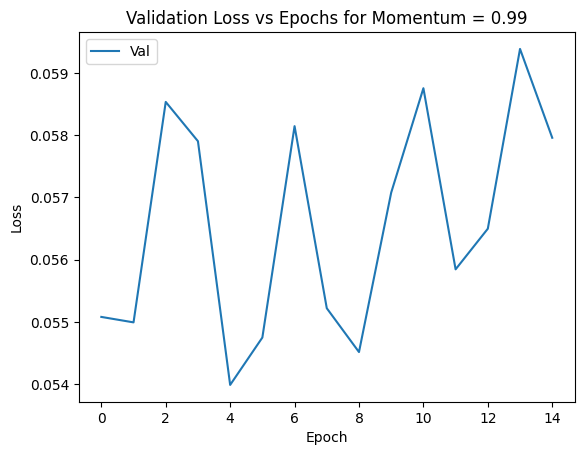

In [ ]:
momentum_list = [0, 0.5, 0.9, 0.99]
best_mom = find_momentum(model, train_loader, val_loader, criterion, best_lr, momentum_list)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Freeze the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

n_class = 3

# Modify the last layer of the model to have three output classes
model.classification = nn.Sequential(
    nn.Dropout2d(p=0.1),
    nn.Conv2d(in_channels=in_features, out_channels=n_class, kernel_size=1, padding=0),
    nn.Upsample(scale_factor=8, mode='bilinear'),
)

# Set the last layer to require gradients
for param in model.classification.parameters():
    param.requires_grad = True

model

DenseASPP(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

## We can see that the output layer has 3 out features which is what we need in our fine tuned model.

In [ ]:
import random
# Set random seeds for reproducibility 
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
opt_lr = "{:.2f}".format(best_lr)
opt_mom = "{:.2f}".format(best_mom)
print(f"Optimal learning rate: {opt_lr}")
print(f"Optimal Momentum:{opt_mom}")

Optimal learning rate: 0.03
Optimal Momentum:0.99


In [ ]:
opt_lr = float(opt_lr)
opt_mom = float(opt_mom)

In [ ]:
model

DenseASPP(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classification.1.weight
classification.1.bias


In [ ]:
def train_epoch(model, device, data_loader, optimizer, criterion):
    """
    Train the model for one epoch.

    Args:
        model (torch.nn.Module): The neural network model to train.
        device (torch.device): The device on which to run the computations.
        data_loader (torch.utils.data.DataLoader): The data loader for the training set.
        optimizer (torch.optim.Optimizer): The optimizer to use for updating the model parameters.
        criterion (torch.nn.Module): The loss function to use for computing the loss.

    Returns:
        epoch_loss (float): The average loss over the entire epoch.
        epoch_acc (float): The accuracy over the entire epoch.
    """

    # Set the model to train mode
    model.train()

    # Initialize epoch loss and accuracy
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0

    # Loop over the training data
    for batch_idx, (data, target) in enumerate(data_loader):
        # Move the data and target tensors to the device (GPU if available)
        data, target = data.to(device), target.to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data.float())
        predicted = torch.argmax(output, dim=1)

        # Convert target tensor from one-hot encoding to class indices
        target = torch.argmax(target, dim=1)

        # Compute the loss
        loss = criterion(output, target)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update epoch loss and accuracy
        epoch_loss += loss.item() * data.size(0)
        epoch_total += target.view(-1).size(0)
        epoch_correct += predicted.view(-1).eq(target.view(-1)).sum().item()

    # Compute epoch loss and accuracy
    epoch_loss /= len(data_loader.dataset)
    epoch_acc = 100. * epoch_correct / epoch_total

    return epoch_loss, epoch_acc



In [ ]:
def evaluate(model, device, data_loader, criterion):
    # set the model to eval mode
    model.eval()
    
    # initialize loss and accuracy
    loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            # move the data and target tensors to the device (GPU if available)
            data, target = data.to(device), target.to(device)

            # forward pass
            output = model(data.float())
            predicted = torch.argmax(output, dim=1)
            # convert target tensor from one-hot encoding to class indices
            target = torch.argmax(target, dim=1)

            # compute the loss
            loss += criterion(output, target).item() * data.size(0)

            # update accuracy
            total += target.view(-1).size(0)
            correct += predicted.view(-1).eq(target.view(-1)).sum().item()

    loss /= len(data_loader.dataset)
    acc = 100. * correct / total

    return loss, acc


In [ ]:
def train_evaluate_test(model, device, train_loader, valid_loader, test_loader, optimizer, criterion, num_epochs, scheduler=None, patience=5):
    # set the model to train mode
    model.train()

    # initialize lists to store losses and accuracies for each epoch
    train_losses = []
    valid_losses = []
    test_losses = []
    train_accs = []
    valid_accs = []
    test_accs = []

    # initialize variables to keep track of best model
    best_model = None
    best_acc = 0.0
    best_loss = float('inf')
    early_stop_counter = 0

    # loop over the specified number of epochs
    for epoch in tqdm(range(num_epochs), desc=f"Training Epochs ({num_epochs})", position=0, leave=True):
        # train the model
        train_loss, train_acc = train_epoch(model, device, train_loader, optimizer, criterion)

        # evaluate the model on validation set
        valid_loss, valid_acc = evaluate(model, device, valid_loader, criterion)

        # evaluate the model on test set
        test_loss, test_acc = evaluate(model, device, test_loader, criterion)

        # print loss and accuracy for each dataset
        print(f'\nEpoch {epoch+1} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
        print(f'Epoch {epoch+1} | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%')
        print(f'Epoch {epoch+1} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

        # append losses and accuracies to respective lists
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
        test_accs.append(test_acc)

        # save the model with best accuracy and lower loss
        if valid_acc > best_acc or (valid_acc == best_acc and valid_loss < best_loss):
            best_acc = valid_acc
            best_loss = valid_loss
            best_model = model.state_dict()
            early_stop_counter = 0  # reset counter if we find a new best model
        else:
            early_stop_counter += 1  # increment counter if we didn't find a new best model
            if early_stop_counter == patience:
                print(f'\nEarly stopping after {epoch+1} epochs.')
                break

        # adjust the learning rate
        if scheduler is not None:
            scheduler.step()

    # save the best model to file
    torch.save(best_model, '/content/drive/MyDrive/Colab Notebooks/best_model.pt')
    print('Best Model Saved in the location content/drive/MyDrive/Colab Notebooks as best_model.pt')

    return train_losses, valid_losses, test_losses, train_accs, valid_accs, test_accs


In [ ]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# Define your model, criterion, optimizer, scheduler, and other parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=opt_lr, momentum=opt_mom,  weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 20

from tqdm import tqdm
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses, valid_losses, test_losses, train_accs, valid_accs, test_accs = train_evaluate_test(model, device, train_loader, val_loader, test_loader, optimizer, criterion, num_epochs, scheduler=scheduler)

Training Epochs (20):   5%|▌         | 1/20 [00:42<13:33, 42.82s/it]


Epoch 1 | Train Loss: 0.2003, Train Accuracy: 92.35%
Epoch 1 | Valid Loss: 0.3079, Valid Accuracy: 89.67%
Epoch 1 | Test Loss: 0.3589, Test Accuracy: 86.84%


Training Epochs (20):  10%|█         | 2/20 [01:24<12:43, 42.41s/it]


Epoch 2 | Train Loss: 0.1964, Train Accuracy: 92.68%
Epoch 2 | Valid Loss: 0.3177, Valid Accuracy: 89.22%
Epoch 2 | Test Loss: 0.3572, Test Accuracy: 86.66%


Training Epochs (20):  15%|█▌        | 3/20 [02:08<12:08, 42.85s/it]


Epoch 3 | Train Loss: 0.1997, Train Accuracy: 92.34%
Epoch 3 | Valid Loss: 0.3811, Valid Accuracy: 86.85%
Epoch 3 | Test Loss: 0.3894, Test Accuracy: 85.05%


Training Epochs (20):  20%|██        | 4/20 [02:50<11:22, 42.65s/it]


Epoch 4 | Train Loss: 0.2032, Train Accuracy: 92.28%
Epoch 4 | Valid Loss: 0.3466, Valid Accuracy: 88.44%
Epoch 4 | Test Loss: 0.3776, Test Accuracy: 86.20%


Training Epochs (20):  25%|██▌       | 5/20 [03:32<10:37, 42.53s/it]


Epoch 5 | Train Loss: 0.1871, Train Accuracy: 93.04%
Epoch 5 | Valid Loss: 0.3248, Valid Accuracy: 89.27%
Epoch 5 | Test Loss: 0.3616, Test Accuracy: 86.87%


Training Epochs (20):  25%|██▌       | 5/20 [04:14<12:43, 50.89s/it]


Epoch 6 | Train Loss: 0.1926, Train Accuracy: 92.80%
Epoch 6 | Valid Loss: 0.3648, Valid Accuracy: 87.22%
Epoch 6 | Test Loss: 0.3659, Test Accuracy: 85.64%

Early stopping after 6 epochs.


Best Model Saved in the location content/drive/MyDrive/Colab Notebooks as best_model.pt


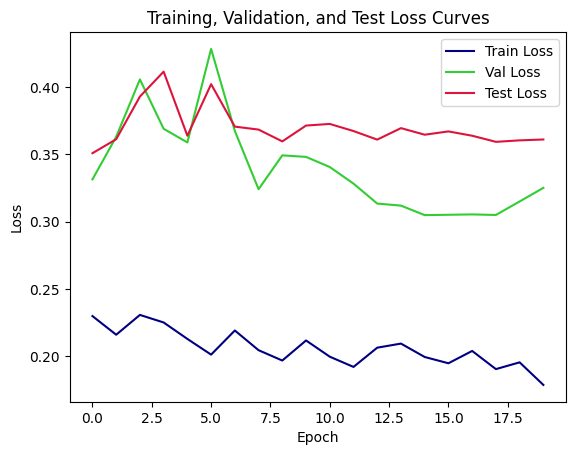

In [ ]:
import matplotlib.pyplot as plt

# Plot the training, validation, and test loss curves with labeled colors

plt.plot(train_losses, label='Train Loss', color='navy')
plt.plot(valid_losses, label='Val Loss', color='limegreen')
plt.plot(test_losses, label='Test Loss', color='crimson')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Curves')
plt.legend()
plt.show()

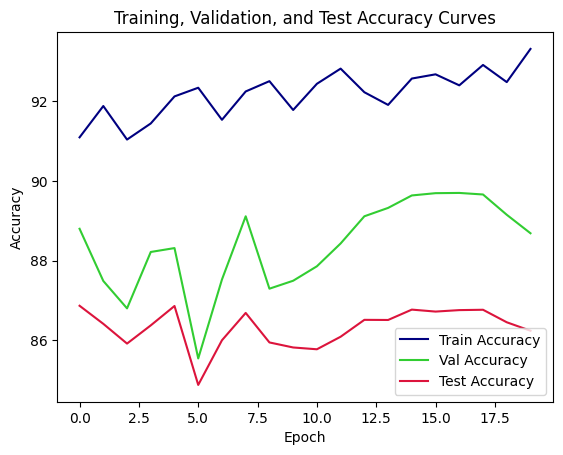

In [ ]:


# Plot the training, validation, and test accuracy curves with labeled colors

plt.plot(train_accs, label='Train Accuracy', color='navy')
plt.plot(valid_accs, label='Val Accuracy', color='limegreen')
plt.plot(test_accs, label='Test Accuracy', color='crimson')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy Curves')
plt.legend()
plt.show()

## Therefore, we have trained, evaulated and tested the model and the accuracies and losses for each dataset look like above.


### Let's load the saved model and plot the input image, target image and predicted image. 

In [ ]:
#Let's load the saved model
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/best_model.pt'))

<All keys matched successfully>

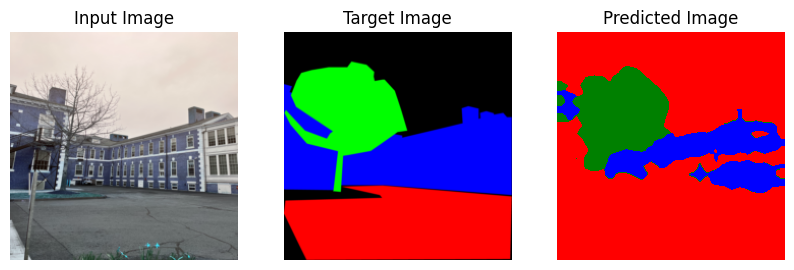

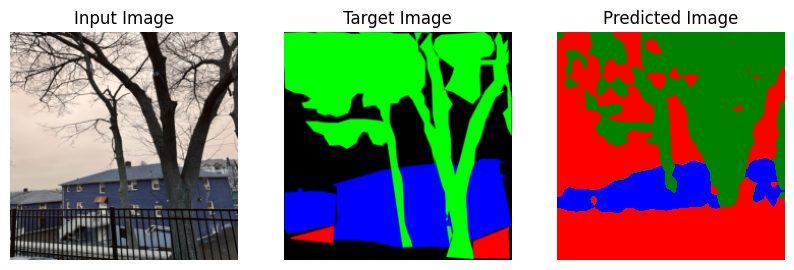

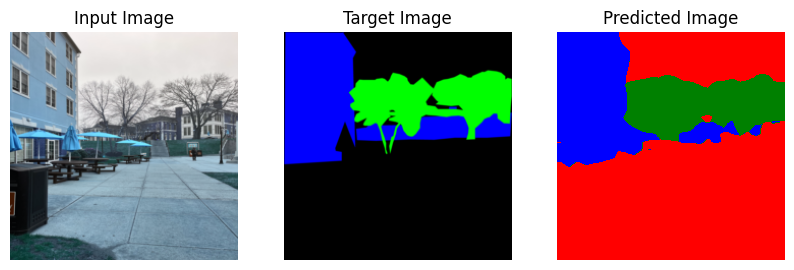

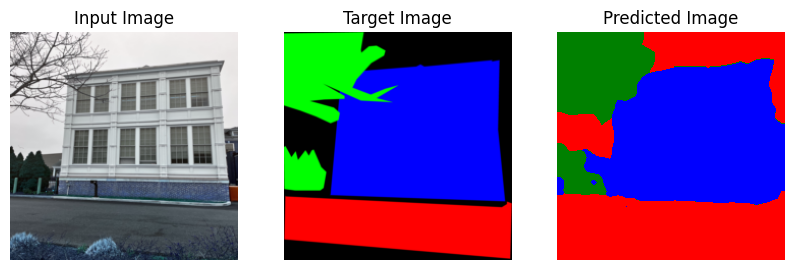

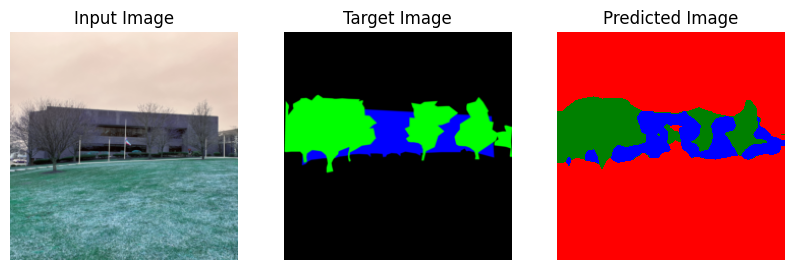

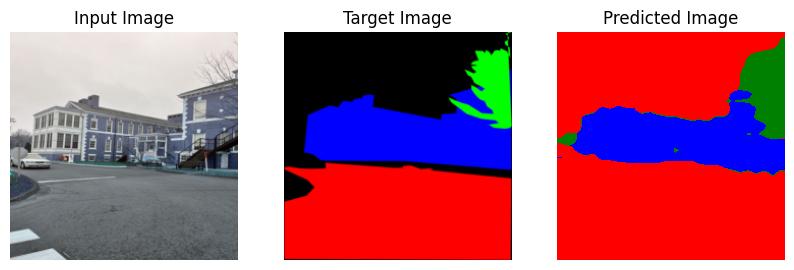

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# create a test dataloader
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= model.to(device)

# set the model to evaluation mode
model.eval()

# define a custom color map
custom_cmap = colors.ListedColormap(['red', 'green', 'blue'])

# plot each input, target, and predicted image
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)
        # forward pass
        outputs = model(images.float())

        # plot each pair of input, target, and predicted images
        for i in range(images.size(0)):
            # convert tensors to numpy arrays and transpose
            image = images[i].cpu().numpy().transpose((1, 2, 0))
            target = targets[i].cpu().numpy()
            target = target.transpose((1, 2, 0))  # shape: (height, width, num_classes)
            #target = target[:, :, 0]  # take the first channel (assuming buildings is channel 0)
            predicted = outputs[i].argmax(dim=0).cpu().numpy()
            # plot images side-by-side
            fig, axs = plt.subplots(1, 3, figsize=(10, 5))
            axs[0].imshow(image)
            axs[0].axis('off')
            axs[0].set_title('Input Image')
            axs[1].imshow(target, cmap=custom_cmap)
            axs[1].axis('off')
            axs[1].set_title('Target Image')
            axs[2].imshow(predicted, cmap=custom_cmap)
            axs[2].axis('off')
            axs[2].set_title('Predicted Image')
            plt.show()

### In the predicted images above, the class road, which is set as the Red channel is not seen because the background has also been set as red which is why the road is not seen. Let's print the predicted class and the target classes for each images.

Target class: [0 1 2]
Predicted class: [0 1 2]


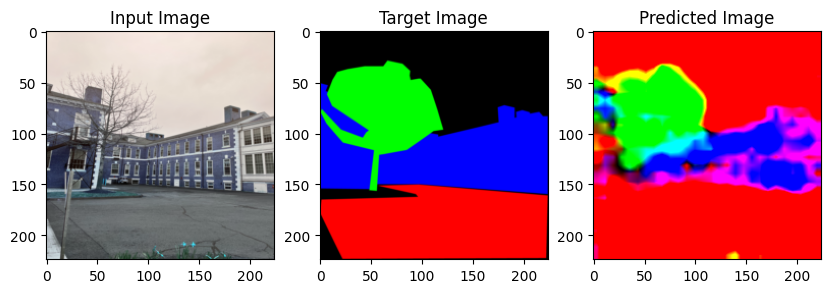

Target class: [0 1 2]
Predicted class: [0 1 2]


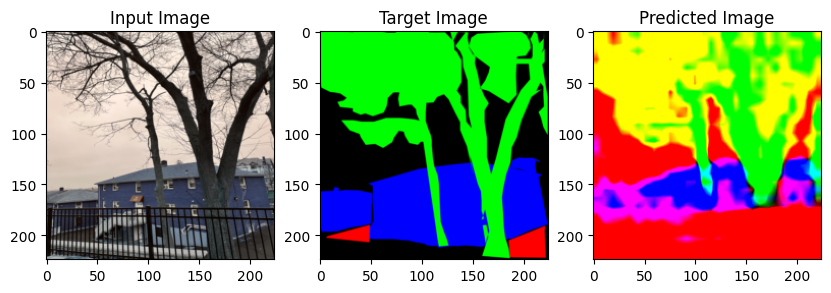

Target class: [0 1 2]
Predicted class: [0 1 2]


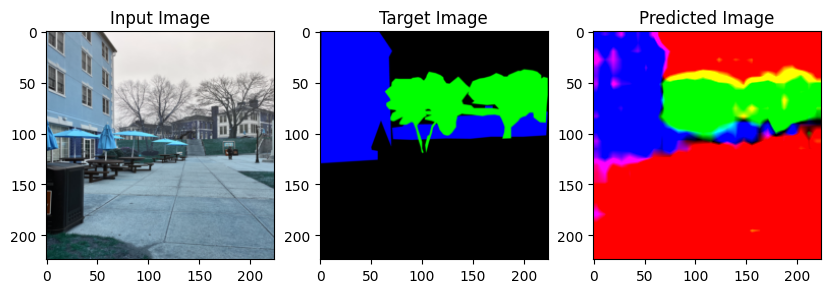

Target class: [0 1 2]
Predicted class: [0 1 2]


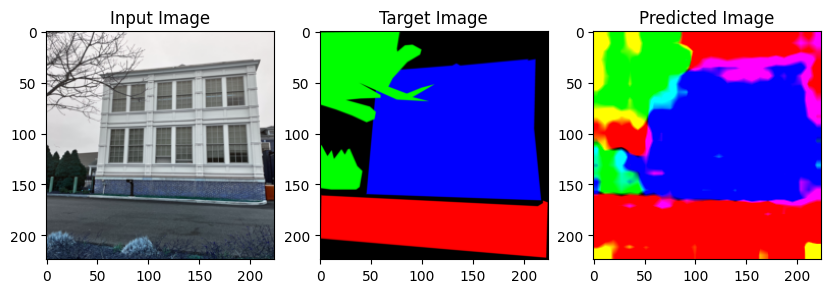

Target class: [0 1 2]
Predicted class: [0 1 2]


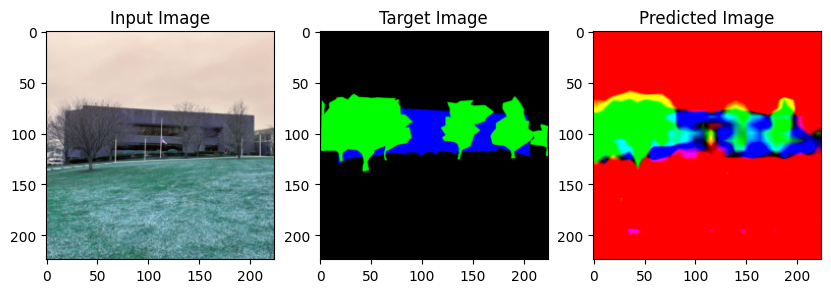

Target class: [0 1 2]
Predicted class: [0 1 2]


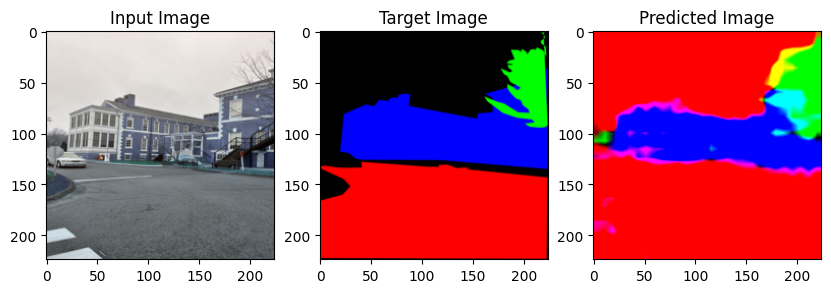

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# create a test dataloader
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

model= model.to(device)

# set the model to evaluation mode
model.eval()

# define a custom color map
custom_cmap = colors.ListedColormap(['black','red', 'green', 'blue'])

# plot each input, target, and predicted image
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)
        # forward pass
        predicted = model(images.float())

        # plot each pair of input, target, and predicted images
        for i in range(images.size(0)):
            # convert tensors to numpy arrays and transpose
            input_image = images[i].cpu().numpy().transpose((1, 2, 0))
            target_image = targets[i].cpu().numpy().transpose((1, 2, 0))
            predicted_image = predicted[i].cpu().numpy().transpose((1, 2, 0))

            # Get the index of the maximum value of each pixel in the predicted image
            predicted_class = np.unique(np.argmax(predicted_image, axis=-1))

            # Get the index of the maximum value of each pixel in the target image
            target_class = np.unique(np.argmax(target_image, axis=-1))

            # Print the class of the target and predicted image
            print('Target class:', target_class)
            print('Predicted class:', predicted_class)
            # Plot the input, target, and predicted images
            fig, axs = plt.subplots(1, 3, figsize=(10, 5))
            axs[0].imshow(input_image)
            axs[0].set_title('Input Image')
            axs[1].imshow(target_image, cmap=custom_cmap)
            axs[1].set_title('Target Image')
            axs[2].imshow(predicted_image, cmap=custom_cmap)
            axs[2].set_title('Predicted Image')
            plt.show()


## I had made another model with Building = red, trees= green and road= blue and the model had been saved as DenseASPP_finetuned.pth. Let's load the model below and see the results. You need to uncomment the 7th cell and run that for this model to work. 

In [ ]:
# Load the model
model1 = DenseASPP(Model_CFG)
# Freeze the pre-trained layers
for param in model1.parameters():
    param.requires_grad = False

n_class = 3

last_layer = model1.classification[-2] # Access the second to last layer of the classification module
in_features = last_layer.weight.size(1)
print("Number of input features:", in_features)

# Modify the last layer of the model to have three output classes
model1.classification = nn.Sequential(
    nn.Dropout2d(p=0.1),
    nn.Conv2d(in_channels=in_features, out_channels=n_class, kernel_size=1, padding=0),
    nn.Upsample(scale_factor=8, mode='bilinear'),
)

# Set the last layer to require gradients
for param in model1.classification.parameters():
    param.requires_grad = True

#device='cpu'
model1.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DenseASPP_finetuned.pth'))



<ipython-input-194-8a2e3d5b6e28>:107: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


Number of input features: 1744


<All keys matched successfully>

Target class: [0 1 2]
Predicted class: [0 1 2]


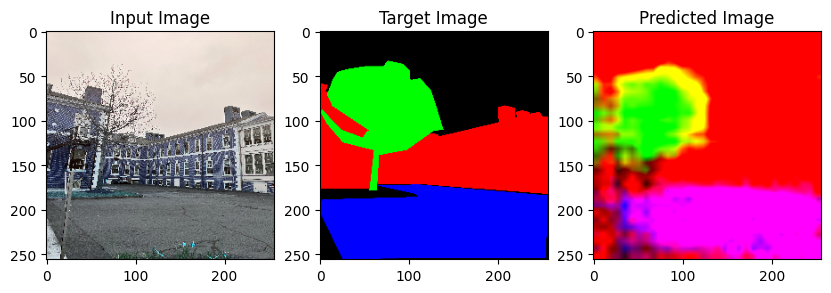

Target class: [0 1 2]
Predicted class: [0 1]


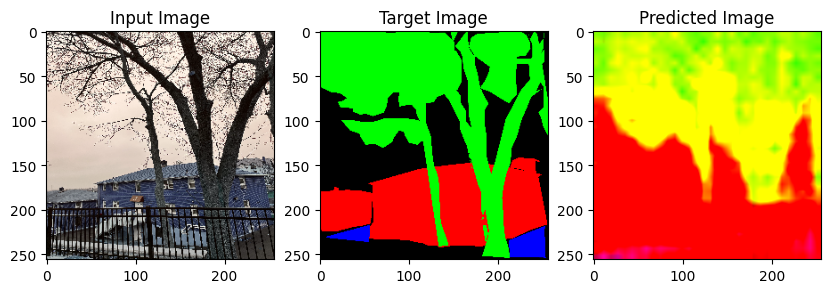

Target class: [0 1]
Predicted class: [0 1 2]


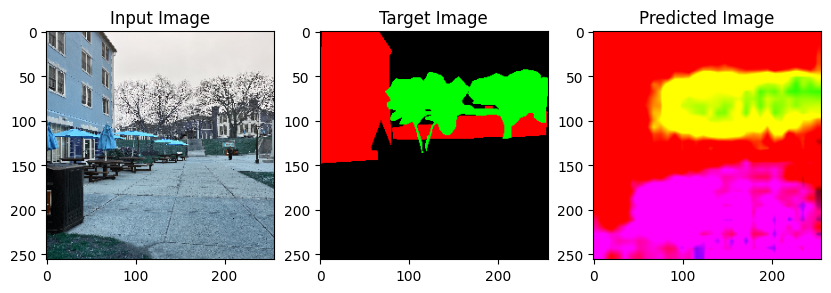

Target class: [0 1 2]
Predicted class: [0 1 2]


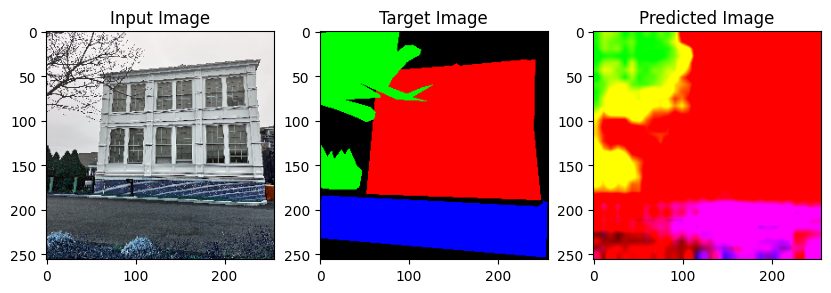

Target class: [0 1]
Predicted class: [0 1 2]


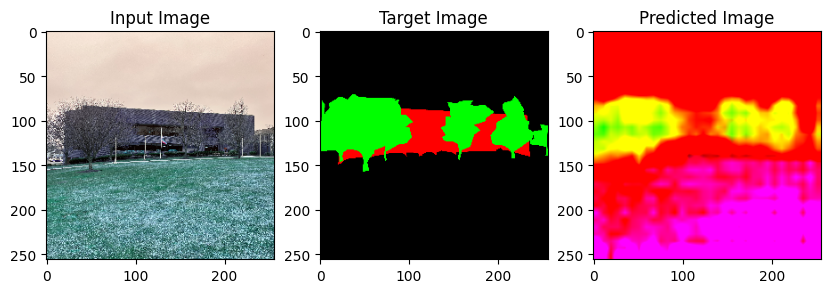

Target class: [0 1 2]
Predicted class: [0 1 2]


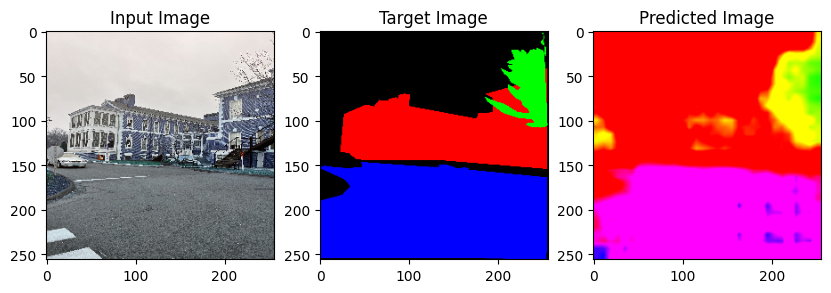

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# create a test dataloader
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

model1= model1.to(device)

# set the model to evaluation mode
model1.eval()

# define a custom color map
custom_cmap = colors.ListedColormap(['black','red', 'green', 'blue'])

# plot each input, target, and predicted image
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        targets = targets.to(device)
        # forward pass
        predicted = model1(images.float())

        # plot each pair of input, target, and predicted images
        for i in range(images.size(0)):
            # convert tensors to numpy arrays and transpose
            input_image = images[i].cpu().numpy().transpose((1, 2, 0))
            target_image = targets[i].cpu().numpy().transpose((1, 2, 0))
            predicted_image = predicted[i].cpu().numpy().transpose((1, 2, 0))

            # Get the index of the maximum value of each pixel in the predicted image
            predicted_class = np.unique(np.argmax(predicted_image, axis=-1))

            # Get the index of the maximum value of each pixel in the target image
            target_class = np.unique(np.argmax(target_image, axis=-1))

            # Print the class of the target and predicted image
            print('Target class:', target_class)
            print('Predicted class:', predicted_class)
            # Plot the input, target, and predicted images
            fig, axs = plt.subplots(1, 3, figsize=(10, 5))
            axs[0].imshow(input_image)
            axs[0].set_title('Input Image')
            axs[1].imshow(target_image, cmap=custom_cmap)
            axs[1].set_title('Target Image')
            axs[2].imshow(predicted_image, cmap=custom_cmap)
            axs[2].set_title('Predicted Image')
            plt.show()


So as shown above, the roads are seen in the predicted image but, the buildings which was set to red is not seen due to red background.  

### Conclusion : Even though we can't see the class that was originally set to set Red color in the target image while plotting the predicted image, if we print the target class and predicted class they are same for the images as shown above.

###When plotting with the custom colormap, the color for the red class is not distinguishable from the black background color. However, since the target class and predicted class are the same, we can conclude that the model is correctly predicting the classes, even though it may be difficult to visually verify the results for the red class.

##Deployment

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 85.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7

In [ ]:

Model_CFG = {
    'bn_size': 4,
    'drop_rate': 0,
    'growth_rate': 48,
    'num_init_features': 96,
    'block_config': (6, 12, 36, 24),

    'dropout0': 0.1,
    'dropout1': 0.1,
    'd_feature0': 512,
    'd_feature1': 128,

    'pretrained_path': "./pretrained/densenet161.pth"
}

In [ ]:
import torch
import torch.nn.functional as F

from torch import nn
from collections import OrderedDict
from torch.nn import BatchNorm2d as bn


class DenseASPP(nn.Module):
    """
    * output_scale can only set as 8 or 16
    """
    def __init__(self, model_cfg, n_class=19, output_stride=8):
        super(DenseASPP, self).__init__()
        bn_size = model_cfg['bn_size']
        drop_rate = model_cfg['drop_rate']
        growth_rate = model_cfg['growth_rate']
        num_init_features = model_cfg['num_init_features']
        block_config = model_cfg['block_config']

        dropout0 = model_cfg['dropout0']
        dropout1 = model_cfg['dropout1']
        d_feature0 = model_cfg['d_feature0']
        d_feature1 = model_cfg['d_feature1']

        feature_size = int(output_stride / 8)

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', bn(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        # block1*****************************************************************************************************
        block = _DenseBlock(num_layers=block_config[0], num_input_features=num_features,
                            bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
        self.features.add_module('denseblock%d' % 1, block)
        num_features = num_features + block_config[0] * growth_rate

        trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
        self.features.add_module('transition%d' % 1, trans)
        num_features = num_features // 2

        # block2*****************************************************************************************************
        block = _DenseBlock(num_layers=block_config[1], num_input_features=num_features,
                            bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
        self.features.add_module('denseblock%d' % 2, block)
        num_features = num_features + block_config[1] * growth_rate

        trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2, stride=feature_size)
        self.features.add_module('transition%d' % 2, trans)
        num_features = num_features // 2

        # block3*****************************************************************************************************
        block = _DenseBlock(num_layers=block_config[2], num_input_features=num_features, bn_size=bn_size,
                            growth_rate=growth_rate, drop_rate=drop_rate, dilation_rate=int(2 / feature_size))
        self.features.add_module('denseblock%d' % 3, block)
        num_features = num_features + block_config[2] * growth_rate

        trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2, stride=1)
        self.features.add_module('transition%d' % 3, trans)
        num_features = num_features // 2

        # block4*****************************************************************************************************
        block = _DenseBlock(num_layers=block_config[3], num_input_features=num_features, bn_size=bn_size,
                            growth_rate=growth_rate, drop_rate=drop_rate, dilation_rate=int(4 / feature_size))
        self.features.add_module('denseblock%d' % 4, block)
        num_features = num_features + block_config[3] * growth_rate

        trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2, stride=1)
        self.features.add_module('transition%d' % 4, trans)
        num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', bn(num_features))
        if feature_size > 1:
            self.features.add_module('upsample', nn.Upsample(scale_factor=2, mode='bilinear'))

        self.ASPP_3 = _DenseAsppBlock(input_num=num_features, num1=d_feature0, num2=d_feature1,
                                      dilation_rate=3, drop_out=dropout0, bn_start=False)

        self.ASPP_6 = _DenseAsppBlock(input_num=num_features + d_feature1 * 1, num1=d_feature0, num2=d_feature1,
                                      dilation_rate=6, drop_out=dropout0, bn_start=True)

        self.ASPP_12 = _DenseAsppBlock(input_num=num_features + d_feature1 * 2, num1=d_feature0, num2=d_feature1,
                                       dilation_rate=12, drop_out=dropout0, bn_start=True)

        self.ASPP_18 = _DenseAsppBlock(input_num=num_features + d_feature1 * 3, num1=d_feature0, num2=d_feature1,
                                       dilation_rate=18, drop_out=dropout0, bn_start=True)

        self.ASPP_24 = _DenseAsppBlock(input_num=num_features + d_feature1 * 4, num1=d_feature0, num2=d_feature1,
                                       dilation_rate=24, drop_out=dropout0, bn_start=True)
        num_features = num_features + 5 * d_feature1

        self.classification = nn.Sequential(
            nn.Dropout2d(p=dropout1),
            nn.Conv2d(in_channels=num_features, out_channels=n_class, kernel_size=1, padding=0),
            nn.Upsample(scale_factor=8, mode='bilinear'),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform(m.weight.data)

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, _input):
        feature = self.features(_input)

        aspp3 = self.ASPP_3(feature)
        feature = torch.cat((aspp3, feature), dim=1)

        aspp6 = self.ASPP_6(feature)
        feature = torch.cat((aspp6, feature), dim=1)

        aspp12 = self.ASPP_12(feature)
        feature = torch.cat((aspp12, feature), dim=1)

        aspp18 = self.ASPP_18(feature)
        feature = torch.cat((aspp18, feature), dim=1)

        aspp24 = self.ASPP_24(feature)
        feature = torch.cat((aspp24, feature), dim=1)

        cls = self.classification(feature)

        return cls


class _DenseAsppBlock(nn.Sequential):
    """ ConvNet block for building DenseASPP. """

    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True):
        super(_DenseAsppBlock, self).__init__()
        if bn_start:
            self.add_module('norm1', bn(input_num, momentum=0.0003)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', bn(num1, momentum=0.0003)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),

        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(_DenseAsppBlock, self).forward(_input)

        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)

        return feature


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, dilation_rate=1):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', bn(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', bn(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, dilation=dilation_rate, padding=dilation_rate, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, dilation_rate=1):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate,
                                bn_size, drop_rate, dilation_rate=dilation_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features, stride=2):
        super(_Transition, self).__init__()
        self.add_module('norm', bn(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False))
        if stride == 2:
            self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=stride))
            
if __name__ == "__main__":
    model = DenseASPP(Model_CFG)
    print(model)            

<ipython-input-4-8a2e3d5b6e28>:107: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


DenseASPP(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [ ]:
import gradio as gr
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn

# Define a function that performs semantic segmentation on an input image
def semantic_segmentation(input_image):
    # Load the model
    test_model = DenseASPP(Model_CFG)
    # Freeze the pre-trained layers
    for param in test_model.parameters():
        param.requires_grad = False

    n_class = 3

    last_layer = test_model.classification[-2] # Access the second to last layer of the classification module
    in_features = last_layer.weight.size(1)
    print("Number of input features:", in_features)

    # Modify the last layer of the model to have three output classes
    test_model.classification = nn.Sequential(
        nn.Dropout2d(p=0.1),
        nn.Conv2d(in_channels=in_features, out_channels=n_class, kernel_size=1, padding=0),
        nn.Upsample(scale_factor=8, mode='bilinear'),
    )

    # Set the last layer to require gradients
    for param in test_model.classification.parameters():
        param.requires_grad = True

    state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/best_model.pt')
    test_model.load_state_dict(state_dict)
    test_model.eval()

    # Define the transformation to be applied to the input image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5664, 0.5783, 0.5765], [0.2889, 0.2527, 0.2364])
    ])



    input_image_pil = Image.fromarray(input_image.astype('uint8'), 'RGB')
    input_tensor = transform(input_image_pil)
    input_batch= input_tensor.unsqueeze(0)

    # Perform semantic segmentation on the input image
    with torch.no_grad():
        output_tensor = test_model(input_batch.float())
        print(output_tensor.shape)
        predicted_class = torch.argmax(output_tensor, dim=1)
        print(predicted_class)
        print(predicted_class.shape)

    # Convert the predicted class tensor to a numpy array
    predicted_class_np = predicted_class.squeeze(0).numpy().astype(np.uint8)

    # Map class labels to colors
    color_map = {
        0: (255, 0, 0),  # road
        1: (0, 255, 0),  # tree
        2: (0, 0, 255),  # building
    }

    # Create a new array of shape (height, width, 3) to store the colored image
    height, width = predicted_class_np.shape
    predicted_image_np = np.zeros((height, width, 3), dtype=np.uint8)

    # Fill in the new array with the appropriate colors
    for class_label, color in color_map.items():
        predicted_image_np[predicted_class_np == class_label] = color

    
    # Resize the predicted image to the same size as the input image
    predicted_image_resized_np = np.array(Image.fromarray(predicted_image_np).resize((125,125), resample=Image.BILINEAR))
    # Return the colored image
    return predicted_image_resized_np

# Define the input interface
input_interface = gr.inputs.Image(label="Input Image")

# Define the output interface
output_interface = gr.outputs.Image(type="numpy", label="Segmented Image")

# Create the Gradio interface in debug mode
gr.Interface(semantic_segmentation, inputs=input_interface, outputs=output_interface).launch(share=True)


/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://41b71c6abc1a835d39.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
